In [1]:
import geopandas
import matplotlib.pyplot as mp
import cartopy
import numpy
import xarray
import cmocean

In [2]:
ca_eco_l3 = geopandas.read_file('../ca_eco_l3/ca_eco_l3.shp')

In [3]:
type(ca_eco_l3)

geopandas.geodataframe.GeoDataFrame

In [4]:
ca_eco_l3.head()

,US_L3CODE,US_L3NAME,NA_L3CODE,NA_L3NAME,NA_L2CODE,NA_L2NAME,NA_L1CODE,NA_L1NAME,STATE_NAME,EPA_REGION,L3_KEY,L2_KEY,L1_KEY,geometry
0,1,Coast Range,7.1.8,Coast Range,7.1,MARINE WEST COAST FOREST,7,MARINE WEST COAST FOREST,California,10,1 Coast Range,7.1 MARINE WEST COAST FOREST,7 MARINE WEST COAST FOREST,(POLYGON ((-2284145.645799998 1942003.85980000...
1,13,Central Basin and Range,10.1.5,Central Basin and Range,10.1,COLD DESERTS,10,NORTH AMERICAN DESERTS,California,10,13 Central Basin and Range,10.1 COLD DESERTS,10 NORTH AMERICAN DESERTS,"(POLYGON ((-1856589.398599999 1762342.1763, -1..."
2,14,Mojave Basin and Range,10.2.1,Mojave Basin and Range,10.2,WARM DESERTS,10,NORTH AMERICAN DESERTS,California,9,14 Mojave Basin and Range,10.2 WARM DESERTS,10 NORTH AMERICAN DESERTS,"POLYGON ((-1899479.7774 1806588.553400001, -18..."
3,4,Cascades,6.2.7,Cascades,6.2,WESTERN CORDILLERA,6,NORTHWESTERN FORESTED MOUNTAINS,California,10,4 Cascades,6.2 WESTERN CORDILLERA,6 NORTHWESTERN FORESTED MOUNTAINS,POLYGON ((-2131525.308100002 2400780.837399999...
4,5,Sierra Nevada,6.2.12,Sierra Nevada,6.2,WESTERN CORDILLERA,6,NORTHWESTERN FORESTED MOUNTAINS,California,9,5 Sierra Nevada,6.2 WESTERN CORDILLERA,6 NORTHWESTERN FORESTED MOUNTAINS,"POLYGON ((-2069803.4551 2205701.5616, -2069451..."


In [5]:
sierras_series = ca_eco_l3.loc[4,:]

In [6]:
sierras_series

US_L3CODE                                                     5
US_L3NAME                                         Sierra Nevada
NA_L3CODE                                                6.2.12
NA_L3NAME                                         Sierra Nevada
NA_L2CODE                                                   6.2
NA_L2NAME                                    WESTERN CORDILLERA
NA_L1CODE                                                     6
NA_L1NAME                       NORTHWESTERN FORESTED MOUNTAINS
STATE_NAME                                           California
EPA_REGION                                                    9
L3_KEY                                         5  Sierra Nevada
L2_KEY                                  6.2  WESTERN CORDILLERA
L1_KEY                       6  NORTHWESTERN FORESTED MOUNTAINS
geometry      POLYGON ((-2069803.4551 2205701.5616, -2069451...
Name: 4, dtype: object

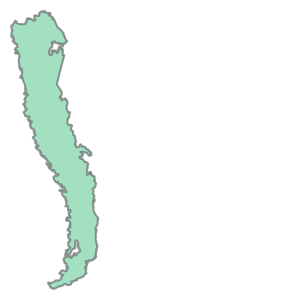

In [7]:
sierras_series.geometry

In [8]:
states_shapes = cartopy.io.shapereader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
shapes_reader = cartopy.io.shapereader.Reader(states_shapes)

states_name_list = numpy.array(([i.attributes['name'] for i in shapes_reader.records()]))
for i in shapes_reader.records():
    if i.attributes['name']=='California' and i.attributes['iso_a2']=='US':
        CA_object = i
CA_object_no_islands = CA_object.geometry.geoms[-1] # get the last one (the state of Cali)


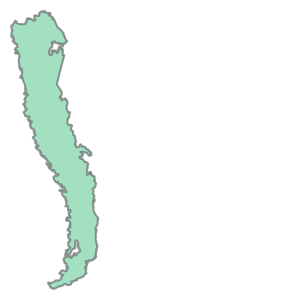

In [9]:
sierras_series.geometry

In [10]:
lon_lo, lon_hi, lat_lo, lat_hi = 235.25, 246.25, 32., 42.5

In [11]:
# topographic data
filename = '/Users/baird/Dropbox/_group_conferences/2017/agu_2017/upgoer_5/code_for_plots/noaa_topo_data/ETOPO1_Ice_g_gmt4.grd'

ncfile = xarray.open_dataset(filename)
ncfile['x']+=360.
topo_data = ncfile['z'].sel(y=slice(lat_lo,lat_hi),x=slice(lon_lo,lon_hi)).values
topo_lat = ncfile['y'].sel(y=slice(lat_lo,lat_hi)).values
topo_lon = ncfile['x'].sel(x=slice(lon_lo,lon_hi)).values


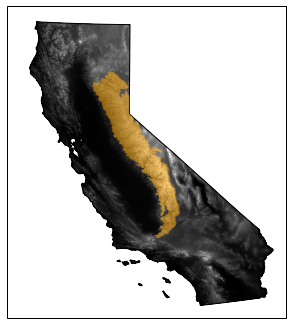

In [13]:
fig = mp.figure(figsize=(5,10))

map_proj = cartopy.crs.LambertConformal(standard_parallels=[lat_lo,lat_hi], \
    central_longitude=0.5*(lon_lo+lon_hi), \
    central_latitude=0.5*(lat_lo+lat_hi))

data_proj = cartopy.crs.AlbersEqualArea(central_longitude=-96.0, \
                            central_latitude=23.0, \
                            false_easting=0.0, \
                            false_northing=0.0, \
                            standard_parallels=(29.5, 45.5), \
                            globe=None)

# From xml file included with shapefile info:
#
# USA Contiguous Albers Equal Area Conic USGS version</mapprojn>
# <albers>
# <stdparll>29.5</stdparll>
# <stdparll>45.5</stdparll>
# <longcm>-96.0</longcm>
# <latprjo>23.0</latprjo>
# <feast>0.0</feast>
# <fnorth>0.0</fnorth>

ax = fig.add_subplot(111, projection=map_proj)
#ax.coastlines(resolution='50m')
ax.set_extent([lon_lo, lon_hi, lat_lo, lat_hi])

ax.add_geometries(CA_object.geometry, crs=cartopy.crs.PlateCarree(), facecolor='None', edgecolor='0')

ax.add_geometries([sierras_series.geometry], crs=data_proj, facecolor='orange', alpha=0.5)

vmin, vmax = -100., 4000.
state_paths = cartopy.mpl.patch.geos_to_path(CA_object.geometry)
for i in range(len(state_paths)):
    topo_image = ax.pcolormesh(topo_lon, topo_lat, topo_data, vmin=vmin, vmax=vmax, cmap=cmocean.cm.gray, transform=cartopy.crs.PlateCarree())
#     #topo_image = ax.contourf(topo_lon_subset, topo_lat_subset, topo_data_subset, levels=levels, extend='both', cmap='magma', transform=cartopy.crs.PlateCarree())
    topo_image.set_clip_path(state_paths[i], transform=cartopy.crs.PlateCarree()._as_mpl_transform(ax))
#topo_image = ax.pcolormesh(topo_lon, topo_lat, topo_data, vmin=vmin, vmax=vmax, cmap='magma', transform=cartopy.crs.PlateCarree())

# states_provinces = cartopy.feature.NaturalEarthFeature(
# category='cultural',
# name='admin_1_states_provinces_lines',
# scale='10m',
# facecolor='none')

# countries = cartopy.feature.NaturalEarthFeature(
# category='cultural',
# name='admin_0_countries',
# scale='10m',
# facecolor='none')

#ax.add_feature(states_provinces, edgecolor='0')
#ax.add_feature(countries, edgecolor='0')

fig.savefig('topo_and_sierras_ecoregion.png', dpi=600, bbox_inches='tight', transparent=True)